In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**1. Data description**

In [4]:
player_data <- read_csv("data/players.csv")
session_data <- read_csv("data/sessions.csv")
joined_data <- player_data |> left_join(session_data) |> group_by(hashedEmail) |> summarize(count = n())
summary_statistics_age <- player_data |> summarize(mean = mean(Age, na.rm = TRUE), max = max(Age, na.rm = TRUE), min = min(Age, na.rm = TRUE)) 

summary_statistics_hours1 <- player_data |> summarize(mean = mean(played_hours, na.rm = TRUE)) 
summary_statistics_hours2 <- player_data |> summarize(max = max(played_hours, na.rm = TRUE), min = min(played_hours, na.rm = TRUE)) 
summary_statistics_hours <- bind_cols(summary_statistics_hours1, summary_statistics_hours2)

summary_statistics_log <- joined_data |> summarize(mean = mean(count), max = max(count), min = min(count))

measure <- c("age", "played hours", "log times")

summary_statistics <- bind_rows(summary_statistics_age, summary_statistics_hours, summary_statistics_log) |> add_column(measure) |> relocate(measure, .before = mean)

summary_statistics

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(hashedEmail)`


measure,mean,max,min
<chr>,<dbl>,<dbl>,<dbl>
age,21.139175,58.0,9
played hours,5.845918,223.1,0
log times,8.193878,310.0,1


- The dataset contains 196 player observations from players.csv.
- The players.csv file includes 7 variables: Age, hashedEmail, name, subscribe, experience, played_hours, and gender, describing each player’s characteristics.
- The sessions.csv file contains 5 variables: hashedEmail, start_time, end_time, original_start_time, and original_end_time, describing each gameplay session.
- An average player age is 21 years. Players typically spent around 6 hours in-game and logged in about 8 times.
- The oldest player is 58 and the youngest is 9. The most active player spent 223.1 hours and logged in 310 times, while some players recorded 0 hours and 1 session.
- Several issues arise: missing values (e.g., in Age) limit completeness; the definition of a “player” is unclear — some created accounts but never played, which affects averages (e.g., excluding inactive players raises mean playtime from 6 to 10 hours). Ethical concerns also exist, particularly around ensuring player privacy and appropriate use of identifiable data such as hashedEmail.

This dataset, once cleaned and clarified, can support analysis of player behavior patterns and the relationship between demographics (age, experience) and activity levels.

**2. Question**
- Clearly state **one broad question** that you will address, and the **specific question** that you have formulated. Your question should involve **one response variable of interest and one or more explanatory variables**, and should be stated as a question. One common question format is: “Can [explanatory variable(s)] predict [response variable] in [dataset]?”, but you are free to format your question as you choose so long as it is clear. **Describe** clearly how the data will help you address the question of interest. You may need to describe how you plan to wrangle your data to get it into a form where you can apply one of the predictive methods from this class.

- I will be choosing question 2: which "kinds" of players are most likely to contribute a large amount of data? 
- Therefore, my specific question will be: Can the player's age and hours spent on the game predict their level of expertise (experience)? 
- The data will help address this because players’ age, experience, and playtime are all recorded. With 196 observations, the dataset is large enough to split into training and testing sets. I plan to convert the “experience” column from character to factor so models like KNN classification can use it.

**3. Exploratory data analysis and visualization**

measure,mean,max,min
<chr>,<dbl>,<dbl>,<dbl>
age,21.139175,58.0,9
played hours,5.845918,223.1,0


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_bar()`).”


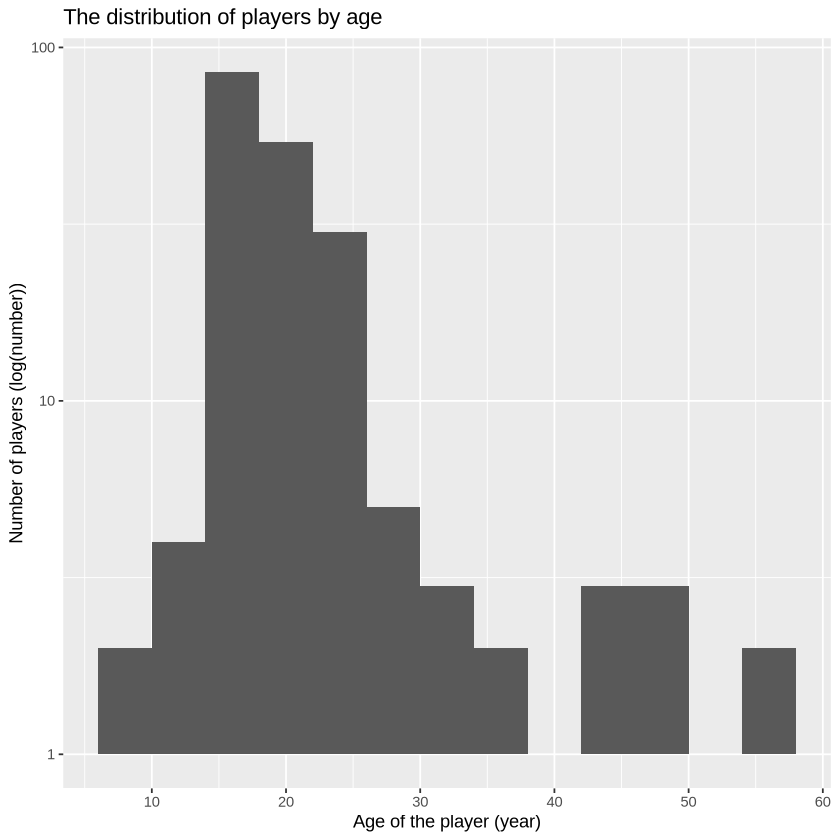

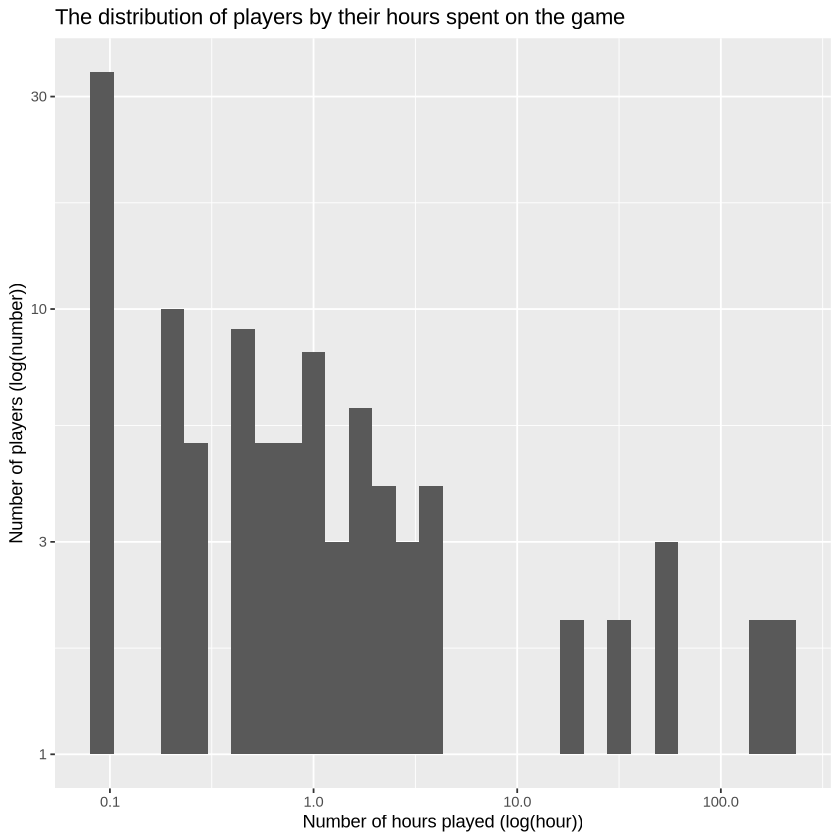

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


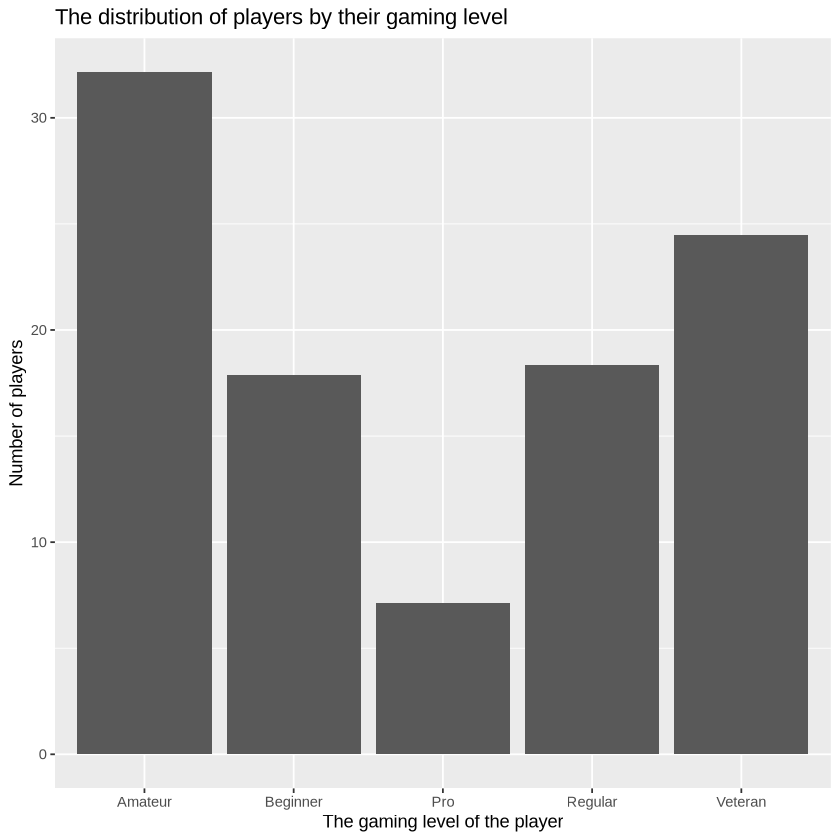

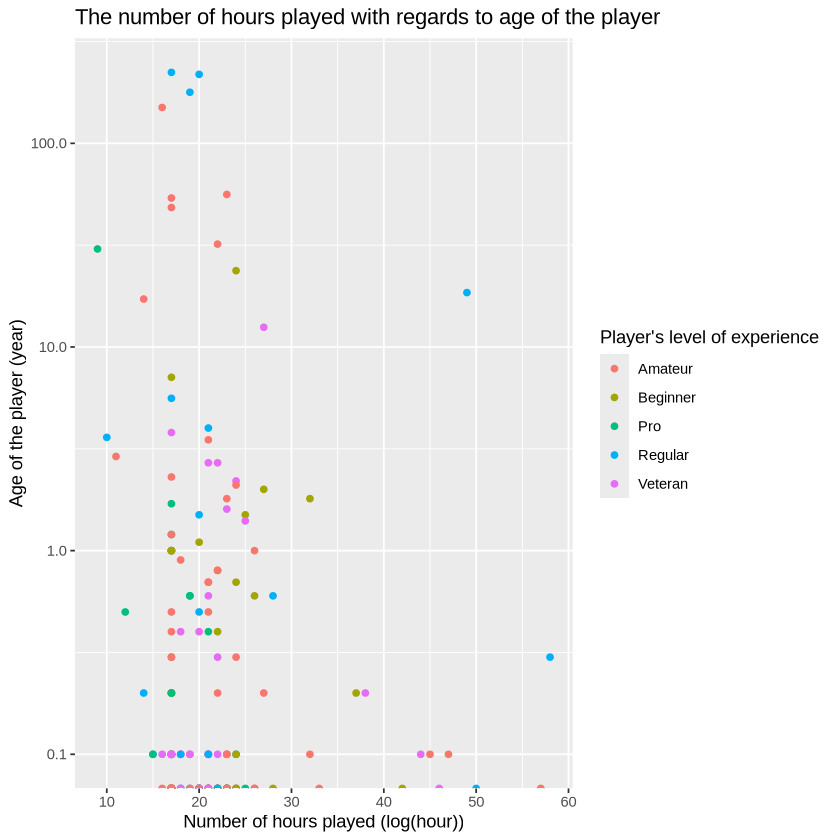

In [7]:
summary_statistics_3 <- summary_statistics |> filter(measure %in% c("played hours" , "age"))
summary_statistics_3
plot_for_age <- player_data |> ggplot(aes(x = Age)) + geom_histogram(binwidth = 4, position = "stack") + scale_y_log10() + labs(x = "Age of the player (year)", y = "Number of players (log(number))", title = "The distribution of players by age")
plot_for_age

plot_for_played_hours <- player_data |> ggplot(aes(x = played_hours)) + geom_histogram() + scale_y_log10() + scale_x_log10()  + labs(x = "Number of hours played (log(hour))", y = "Number of players (log(number))", title = "The distribution of players by their hours spent on the game")
plot_for_played_hours

plot_for_experience <- player_data |> group_by(experience) |> summarize(count = n()) |> mutate(percentage = count/196*100) |> 
ggplot(aes(x = experience, y = percentage)) + geom_bar(stat = "identity") + labs(x = "The gaming level of the player", y = "Number of players", title = "The distribution of players by their gaming level")
plot_for_experience

plot_agevshoursvsexperience <- player_data |> ggplot(aes(x= Age, y = played_hours, color = experience)) + geom_point() + scale_y_log10() + labs(x = "Number of hours played (log(hour))", y = "Age of the player (year)", color = "Player's level of experience", title = "The number of hours played with regards to age of the player")
plot_agevshoursvsexperience

    Broad question:
- From histogram 1, teens and players in their 20s are the target demographic, contributing most data.
- From histogram 2, many players logged in but never played; the majority play little, and only a few very dedicated players are highly active. The number of hours is difficult to approximate (e.g. how many hours "little") because they are scaled by log10 for the sake of visual clarity.
- The barplot shows player levels are polarised: most players or either amateurs or veterans (over 30% are amateurs, and nearly 25% are veterans)

    Specific question:
- The scatterplot shows no linear relationship between age, playtime, and experience. Most players are young (teens) with all sorts of levels of experience and amount of hours played. Therefore, when constructing a predictive model, KNN classification is appropriate because the model doesn't impose any shape of relationship (linear, circular, ...) on the data. 

**4. Method and plan**

To answer “Can the player’s age and hours spent on the game predict their level of expertise (experience)?”, I will use KNN Classification, which is appropriate for this dataset. The predictors are Age and played_hours, and the label to be predicted is experience (to be converted to a factor).
- I will split the data 75–25 for training and testing, as most data should train the model while some must test it.
- I will perform (less or) around 5-fold cross-validation (since the dataset is small, ~200 observations) to find the "best" K.
- A potential limitation is class imbalance—there are far more amateurs and veterans than other levels, which may bias predictions toward those groups.